In [1]:
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
from collections import deque
from matplotlib import cm
from tqdm import tqdm

In [2]:
class GridEnv:
    def __init__(self, m=3, n=4, gamma=0.9):
        self.m = m
        self.n = n
        self.grid = None
        self.wall = (m // 2, n // 2 - 1)
        self.goal = (0, n - 1)
        self.pit = (1, n - 1)
        self.gamma = gamma
        self.reset()

        self.action_map = {
            0: "↑",
            1: "→",
            2: "↓",
            3: "←",
        }
        self.policy = None
        self.Q = None

    def reset(self):
        self.grid = [[0] * self.n for _ in range(self.m)]
        self.grid = np.array(self.grid).astype(np.float)
        self.grid[self.goal[0], self.goal[1]] = 1
        self.grid[1, -1] = -1

    def render(self, values=None):
        fig, ax = plt.subplots()
        plt.gcf().canvas.mpl_connect(
            "key_release_event",
            lambda event: [exit(0) if event.key == "escape" else None],
        )
        ax.imshow(self.grid, cmap=cm.get_cmap("YlGn"))
        ax.grid(True, which="major", axis="both")
        ax.set_xticks(np.arange(-0.5, self.n, 1))
        ax.set_yticks(np.arange(-0.5, self.m, 1))
        ax.set_xticklabels([])
        ax.set_yticklabels([])

        x_start = -0.5
        x_end = self.n
        y_start = -0.5
        y_end = self.m

        jump_x = (x_end - x_start) / (2.0 * self.n)
        jump_y = (y_end - y_start) / (2.0 * self.m)
        x_positions = np.linspace(start=x_start, stop=x_end, num=self.n, endpoint=False)
        y_positions = np.linspace(start=y_start, stop=y_end, num=self.m, endpoint=False)

        for y_index, y in enumerate(y_positions):
            for x_index, x in enumerate(x_positions):
                if self.wall == (x_index, y_index):
                    continue
                if values is None:
                    label = self.action_map[self.policy[y_index, x_index]]
                else:
                    label = str(round(values[y_index][x_index], 2))
                if (y_index, x_index) == self.pit:
                    label = -1
                if (y_index, x_index) == self.goal:
                    label = 1
                text_x = x + jump_x * 0.5
                text_y = y + jump_y * 0.5
                ax.text(text_x, text_y, label, color="black", ha="center", va="center")

        plt.pause(0.1)
        _ = plt.show()

    def step(self, curr_state, action):
        assert action <= 3 and action >= 0, "action out of range"

        m = self.m
        n = self.n
        rand = np.random.rand()

        if action == 0:
            if rand <= 0.8:
                state = (max(curr_state[0] - 1, 0), curr_state[1])
            elif rand > 0.8 and rand <= 0.9:
                state = (curr_state[0], max(curr_state[1] - 1, 0))
            else:
                state = (curr_state[0], min(curr_state[1] + 1, n - 1))

        if action == 1:
            if rand <= 0.8:
                state = (curr_state[0], min(curr_state[1] + 1, n - 1))
            elif rand > 0.8 and rand <= 0.9:
                state = (max(curr_state[0] - 1, 0), curr_state[1])
            else:
                state = (min(curr_state[0] + 1, m - 1), curr_state[1])

        if action == 2:
            if rand <= 0.8:
                state = (min(curr_state[0] + 1, m - 1), curr_state[1])
            elif rand > 0.8 and rand <= 0.9:
                state = (curr_state[0], max(curr_state[1] - 1, 0))
            else:
                state = (curr_state[0], min(curr_state[1] + 1, n - 1))

        if action == 3:
            if rand <= 0.8:
                state = (curr_state[0], max(curr_state[1] - 1, 0))
            elif rand > 0.8 and rand <= 0.9:
                state = (max(curr_state[0] - 1, 0), curr_state[1])
            else:
                state = (min(curr_state[0] + 1, m - 1), curr_state[1])

        if state == self.wall:
            state = curr_state

        done = False
        reward = 0
        if state in [self.pit, self.goal]:
            done = True
            reward = -1 if state == self.pit else 1

        return state, reward, done

    def get_qvalues(self):
        Q = {(i, j): np.random.rand(4) for i in range(self.m) for j in range(self.n)}
        return Q

    def get_policy(self, Q):
        policy = [[0] * self.n for _ in range(self.m)]
        for k, v in Q.items():
            policy[k[0]][k[1]] = np.argmax(v)
        return np.array(policy)

    def get_action(self, Q, state, eps):
        if np.random.rand() <= 1.0 - eps:
            return np.argmax(Q[state])
        return np.random.randint(4)

    def Q_learning(
        self, episodes=10, rollout_steps=50, alpha=0.85, eps=0.2, Q=None, render=False
    ):
        """
        Off-Policy TD Control
        -> Epsilon greedy policy
        """
        self.Q = Q
        if Q is None:
            self.Q = self.get_qvalues()

        self.policy = self.get_policy(self.Q)
        if render:
            print("Current policy")
            self.render()
        
        for e in tqdm(range(episodes)):
            state = (np.random.randint(self.m), np.random.randint(self.n))
            while state in [self.pit, self.wall, self.goal]:
                state = (np.random.randint(self.m), np.random.randint(self.n))
            action = self.get_action(self.Q, state, eps)
            for step in range(rollout_steps):
                new_state, reward, done = self.step(state, action)
                new_action = np.argmax(self.Q[new_state])
                q_update = self.Q[state][action] + alpha * (
                    reward
                    + self.gamma * self.Q[new_state][new_action]
                    - self.Q[state][action]
                )
                self.Q[state][action] = q_update
                state = new_state
                action = self.get_action(self.Q, state, eps)
                if done:
                    break

            self.policy = self.get_policy(self.Q)
            if render:
                print("Episode: {}/{}".format(e + 1, episodes))
                self.render()

        return self.policy, self.Q

In [3]:
env = GridEnv()

In [4]:
## Start with random Q Values / Policy
policy, Q = env.Q_learning(episodes=10000, render=False)

100%|██████████| 10000/10000 [00:01<00:00, 9394.67it/s]


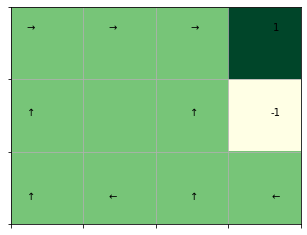

In [5]:
## Final Policy
env.render()